# Simulation of electron-nuclear spin dynamics

This notebook allows to simulate the dynamics of a $Er^{3+}$ electron spin ($S = 1/2$) with a $^{183}W$ ($I = 1/2$) down to the pulse level using QuTip (https://qutip.org/docs/latest/).

The exact shape of the pulse used in the simulation is determined upon the experimental relaxation rate of the MW cavity, and can be freely modified by the user to simulate any case scenario.

In [1]:
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from src.utility import *

%matplotlib widget
worker_count = max(cpu_count() - 1, 1)

## Introduction

The system considered is a tensor space of the electron spin S=1/2 and the nuclear spin I=1/2 subspaces.

The coupling of the intrinsic magnetic moment of the electron spin and the nuclear spin is called the hyperfine interaction. Since the magnetic moment of the electron spin is much larger than that of the nuclear spin, the electron strongly influences the dynamics of the surrounding nuclear spins. As a consequence, electrons can be used to manipulate them (see the figure below).

Here, flipping the electron spin (by applying a $\pi$ pulse) changes the quantization axis $\mathbf{m_{\uparrow \downarrow}}$ of the surrounding $^{183}W$ nuclear spins. By choosing the right period $2 \tau$ between the $\pi$ pulses, one can selectively address a single nuclear spin and flip its state. It is upon this technique that all dynamical decoupling sequences stem from.

<img src="figs/Quantization_axis_LB_CaWO4.jpg" width="600"/>

The static spin Hamiltonian comprises the electron and nuclear Zeeman interactions ($H_{EZ}$ and $H_{NZ}$ respectively) as well as the hyperfine interaction:

$$H_0 = H_{EZ} + H_{NZ} + H_{DD}$$

In the following, we choose to express the Hamiltonian exclusively in terms of angular frequencies (i.e. $H / \hbar$ which we will write simply as $H$). Using the secular approximation, the static Hamiltonian of the system in the rotating frame may be written as:

$$H_0 = \vec{\omega_S} \cdot \vec{S} + \vec{\omega_I} \cdot \vec{I} + AS_ZI_z + BS_zI_x + BS_zI_y$$

where $A$ and $B$ are the secular hyperfine coupling constants.

By applying the rotating wave approximation, we can neglect the electron Zeeman interaction so that the static Hamiltonian becomes:

$$H_0 = \vec{\omega_I} \cdot \vec{I} + AS_ZI_z + BS_zI_x + BS_zI_y$$

The total Hamiltonian $H$ comprises the static Hamiltonian $H_0$ as well as the time-dependent Hamiltonian $H_t$ which is simply:

$$H_t = f(t) \sigma_z$$

where $f: t \rightarrow f(t)$ is the pulse function to apply to the electron (which depends on the sequence considered).

#### References
* [Léo Balembois. Magnetic resonance of a single electron spin and its magnetic environment by photon counting. Université Paris-Saclay, 2023.](https://theses.hal.science/tel-04165482)
* [Arthur Schweiger and Gunnar Jeschke. Principles of pulse electron paramagnetic resonance. Oxford University Press, 2001.](https://global.oup.com/academic/product/principles-of-pulse-electron-paramagnetic-resonance-9780198506348?cc=fr&lang=en&)
* [T. H. Taminiau et al. Detection and Control of Individual Nuclear Spins Using a Weakly Coupled Electron Spin. Physical Review Letters 109.13, 2012.](https://link.aps.org/doi/10.1103/PhysRevLett.109.137602)

### Parameters
Frequencies are given in MHz and durations in $\mu s$. Therefore, the time basis will be in $\mu s$.

In [2]:
# Cavity parameters
kappa_c = 2*np.pi*0.400 # rad/us (400 kHz)
kappa = kappa_c

# Spin parameters
h    = 6.6260693e-34       # J.s
mu_N = 5.0507836991e-27    # Nuclear magneton in J/T
g_N  = 0.2355695           # g nuclear 183W (INDC International Nuclear Data Committee)
mu_I = mu_N*g_N            # Nuclear magneton * g nuclear 183W  in J/T

# Magnetic field
B0 = 0.2 # T
theta = 20*np.pi/180 # rad
phi = 0*np.pi/180 # rad
B_field = np.array([B0*np.sin(theta)*np.cos(phi), B0*np.sin(theta)*np.sin(phi), B0*np.cos(theta)])

omega_L = 2*np.pi*mu_I/h*1e-6*B0 # rad/us

# Hyperfine constants
A_sim, B_sim = np.genfromtxt('hyperfine_parameters\832_at_(%.1f,%.1f,%.1f)_W.csv'%(B_field[0]*1e3, B_field[1]*1e3, B_field[2]*1e3), delimiter=',')[1:, -2:].T*1e-3 # MHz
A_list = 2*np.pi*np.array(A_sim[:10]) # rad/us (MHz)
B_list = 2*np.pi*np.array(B_sim[:10]) # rad/us (MHz)

A = A_list[0]
B = B_list[0]

# Pulse parameters
tau = abs((2*10+1)*np.pi/(2*omega_L))
pulse_duration = 700e-3 # us (700 ns)

# Rabi angle of the input MW pulse so that the filtered pulse applies a pi Rabi angle
input_rabi_angle = np.pi * kappa/(2*np.sqrt(kappa_c))
# Corresponding input Rabi frequency
rabi_freq = input_rabi_angle/pulse_duration # MHz

### Setup of the operators and the static Hamiltonian

In [3]:
S = 1/2
nS = int(2*S+1)
(Sx,Sy,Sz) = generate_S(S)

In [4]:
I = 1/2
nI = int(2*I+1)
(Ix,Iy,Iz) = generate_I(I)

In [5]:
# Nuclear Zeeman interaction
omega_Ix = 2*np.pi*mu_I/h*1e-6*B_field[0]
omega_Iy = 2*np.pi*mu_I/h*1e-6*B_field[1]
omega_Iz = 2*np.pi*mu_I/h*1e-6*B_field[2]
H_NZ = tensor(qeye(nS), omega_Ix*Ix + omega_Iy*Iy + omega_Iz*Iz)

# Electron-nuclear dipole-dipole interaction (hyperfine)
H_DD = A*tensor(Sz,Iz) + B*tensor(Sz,Ix) + B*tensor(Sz,Iy)

# Total static Hamiltonian
H0 = H_NZ + H_DD

In [6]:
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.10553258+0.j          1.01435011-0.62846909j  0.        +0.j
   0.        +0.j        ]
 [ 1.01435011+0.62846909j -1.10553258+0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.01486616+0.j
  -0.24258808+0.62846909j]
 [ 0.        +0.j          0.        +0.j         -0.24258808-0.62846909j
  -1.01486616+0.j        ]]

In [7]:
H0.eigenstates()[0]/(2*np.pi) # Eigenenergies in MHz

array([-0.25889387, -0.19386717,  0.19386717,  0.25889387])

In [8]:
H0.eigenstates()[1]

array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[ 0.40023375+0.j        ]
        [-0.77900911-0.48265697j]
        [ 0.        +0.j        ]
        [ 0.        +0.j        ]]                                        ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[ 0.        +0.j        ]
        [ 0.        +0.j        ]
        [-0.28883146+0.j        ]
        [-0.34475521-0.89315185j]]                                        ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[ 0.        +0.j        ]
        [ 0.        +0.j        ]
        [ 0.95737996+0.j        ]
        [-0.10400902-0.26945452j]]                                        ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.91641308+0.j        ]
        [0.34022402+0.21079534j]
        [0.        +0.j 

## Dynamical decoupling with a CPMG sequence

The CPMG sequence consists in first preparing the electron spin in a state of superposition $\left|x\right\rangle = \frac{1}{\sqrt{2}} \left( \left|\uparrow\right\rangle_e + \left|\downarrow\right\rangle_e\right)$ by applying a $(\pi/2)_y$ pulse on the electron spin, which is always first initialized in the ground state $\left|\uparrow\right\rangle_e$.
Then a unit sequence is repeated $N/2$ times, where $N$ is the total number of pulses and $\tau$ is a free evolution time:

$$\tau - (\pi)_x - 2\tau - (\pi)_x - \tau$$

Then, a final $(\pi/2)_y$ pulse allows to effectively measure the electron spin in the x-space by waiting for it to emit a spin photon and fall back into the ground state $\left|\uparrow\right\rangle_e$.

In [9]:
ket0 = H0.eigenstates()[1][-1] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

In [10]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_prep = [tensor(sigmay(),qeye(nI)), projection_CPMG_pulse]

# Pulse sequence on e- spin: sigma_x*pulse(t) (identity on the nuclear spin)
H_t = [tensor(sigmax(),qeye(nI)), calculate_CPMG_pulse]

# Total Hamiltonian
H = [H0, H_t, H_prep]

In [11]:
# Simulation
N_pulses = 20
t = initialize_time_list(N_pulses,tau,pulse_duration,kappa)
Args = {'tau':tau, 'pulse_duration':pulse_duration, 'rabi_freq':rabi_freq, 'kappa':kappa, 'kappa_c':kappa_c, 'N_pulses':N_pulses}

result = mesolve(H, ket0, t, [], [], args=Args)

array([<AxesSubplot:title={'center':'MW pulses sent to the cavity'}>,
       <AxesSubplot:title={'center':'MW pulses inside the cavity'}>],
      dtype=object)

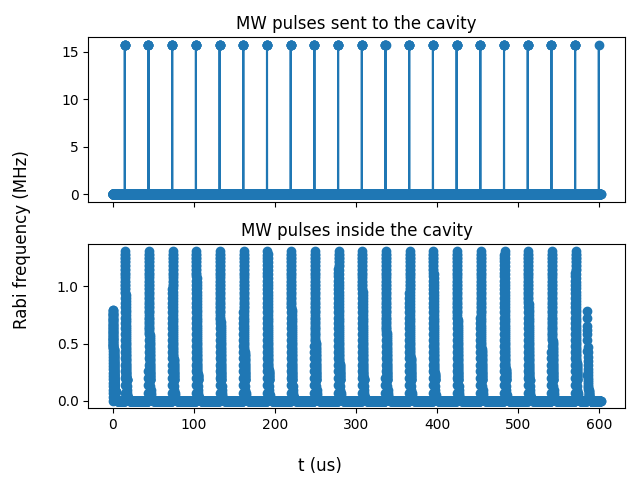

In [12]:
plot_CPMG_pulses(t, Args)

array([<AxesSubplot:ylabel='$<S_x>$'>, <AxesSubplot:ylabel='$<S_y>$'>,
       <AxesSubplot:ylabel='$<S_z>$'>], dtype=object)

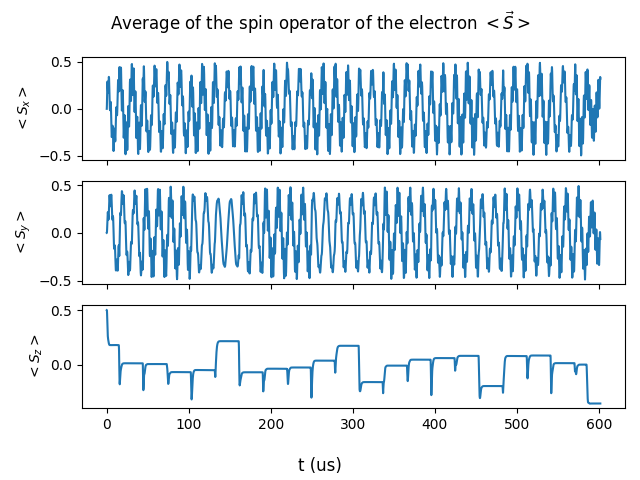

In [13]:
inspect_electron_spin(t, result, S, nI)

array([<AxesSubplot:ylabel='$<I_x>$'>, <AxesSubplot:ylabel='$<I_y>$'>,
       <AxesSubplot:ylabel='$<I_z>$'>], dtype=object)

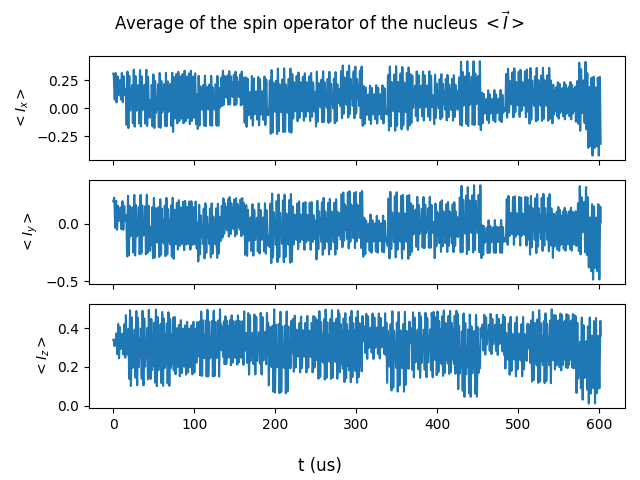

In [14]:
inspect_nuclear_spin(1, t, result, I, nS)

In [15]:
# Simulating for different values of tau for each nuclear spin (see A_list and B_list)
tau_list = np.linspace(5, 30, 2001)
N_pulses = 20

A_list = [A] # rad/us (MHz)
B_list = [B] # rad/us (MHz)
p_x = np.zeros([len(A_list),len(tau_list)])

pool = Pool(worker_count)

for i in range(len(A_list)):
    H_DD = A_list[i]*tensor(Sz,Iz) + B_list[i]*tensor(Sz,Ix) + B_list[i]*tensor(Sz,Iy)
    H = [H_NZ + H_DD, H_t, H_prep]
    
    args = [(H, ket0, {'tau':tau, 'pulse_duration':pulse_duration, 'rabi_freq':rabi_freq, 'kappa':kappa, 'kappa_c':kappa_c, 'N_pulses':N_pulses}, nS, nI) for tau in tau_list]
    
    p_x[i] = pool.starmap(parallelize_CPMG, args)
    
pool.close()

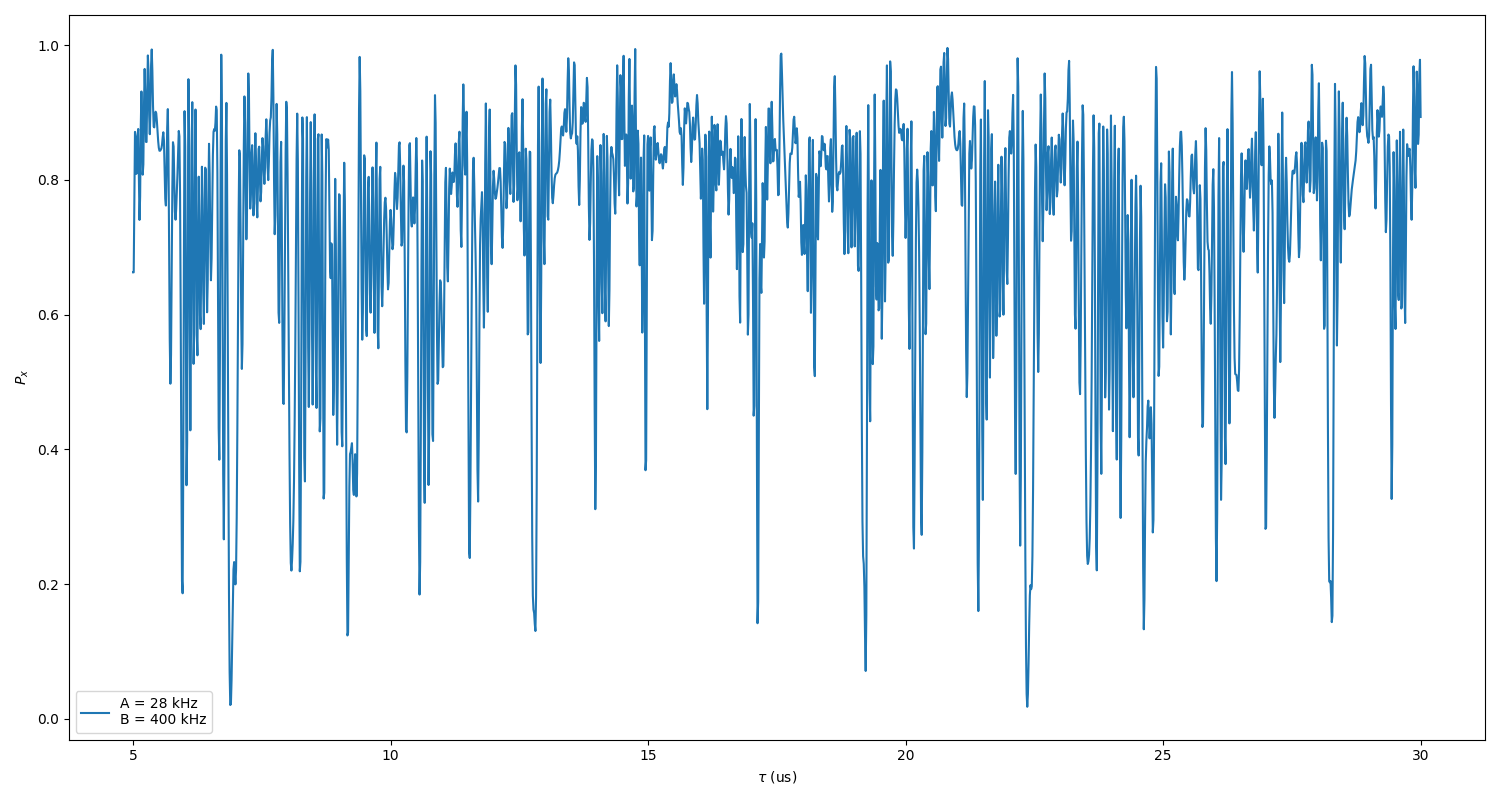

In [16]:
fig, axes = plt.subplots(1, 1, tight_layout=True, figsize=(15,8))
axes.set(
    xlabel=r"$\tau$ (us)",
    ylabel=r"$P_x$"
)

axes.plot(tau_list, p_x[0], label="A = %d kHz\nB = %d kHz"%(A_list[0]/(2*np.pi)*1e3,B_list[0]/(2*np.pi)*1e3))
axes.legend()

### Dynamical decoupling with a CPMG sequence for 2 nuclear spins
To add a new spin (in this case, we want to couple an additional nuclear spin to the electron spin), we just need to generate a new $\vec{I}$ operator and add the new relevant terms to the spin Hamiltonian $H_0$. The same function is used to simulate the sequence using multiprocessing (i.e. parallelize_CPMG), we only need to pass the new Hamiltonian to simulate the new system. 

Here, the static Hamiltonian $H_0$ becomes:

$$H_0 = \omega_{I} (I_{z_1} + I_{z_2}) + A_1S_{Z_1}I_{z_1} + B_1S_{z_1}I_{x_1} + B_1S_{z_1}I_{y_1}  + A_2S_{Z_2}I_{z_2} + B_2S_{z_2}I_{x_2} + B_2S_{z_2}I_{y_2}$$

This example can be used to further increase the number of spins to whatever is needed, but beware that a high number of processor cores may be needed to run the computation efficiently.

In [15]:
A_1 = A_list[0]
B_1 = B_list[0]
A_2 = A_list[4]
B_2 = B_list[4]

In [16]:
I_1 = 1/2
nI_1 = int(2*I_1+1)
(Ix_1,Iy_1,Iz_1) = generate_I(I_1)

In [17]:
I_2 = 1/2
nI_2 = int(2*I_2+1)
(Ix_2,Iy_2,Iz_2) = generate_I(I_2)

In [21]:
# Nuclear Zeeman interaction
H_NZ = tensor(qeye(nS), omega_Ix*Ix_1 + omega_Iy*Iy_1 + omega_Iz*Iz_1, qeye(nI_2)) + tensor(qeye(nS), qeye(nI_1), omega_Ix*Ix_2 + omega_Iy*Iy_2 + omega_Iz*Iz_2)

# Electron-nuclear dipole-dipole interaction (hyperfine)
H_DD = A_1*tensor(Sz,Iz_1,qeye(nI_2)) + B_1*tensor(Sz,Ix_1,qeye(nI_2)) + B_1*tensor(Sz,Iy_1,qeye(nI_2)) + A_2*tensor(Sz,qeye(nI_1),Iz_2) + B_2*tensor(Sz,qeye(nI_1),Ix_2) + B_2*tensor(Sz,qeye(nI_1),Iy_2) 

# Total static Hamiltonian
H0 = H_NZ + H_DD

In [22]:
H0

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 2.72729227+0.j          0.41509137-0.02921036j  1.01435011-0.62846909j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.41509137+0.02921036j -0.51622712+0.j          0.        +0.j
   1.01435011-0.62846909j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 1.01435011+0.62846909j  0.        +0.j          0.51622712+0.j
   0.41509137-0.02921036j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          1.01435011+0.62846909j  0.41509137+0.02921036j
  -2.72729227+0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          1.5135052 +0.j          0.35667065+0.02921036j
  -0.24258

In [23]:
H0.eigenstates()[0]/(2*np.pi) # Eigenenergies in MHz

array([-0.52536595, -0.29155098, -0.09618335, -0.00757821,  0.00757821,
        0.09618335,  0.29155098,  0.52536595])

In [24]:
H0.eigenstates()[1]

array([Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
       Qobj data =
       [[-0.05013052+0.j        ]
        [ 0.39610229+0.02787408j]
        [ 0.09757331+0.06045428j]
        [-0.73735328-0.53192839j]
        [ 0.        +0.j        ]
        [ 0.        +0.j        ]
        [ 0.        +0.j        ]
        [ 0.        +0.j        ]]                                              ,
       Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
       Qobj data =
       [[ 0.        +0.j        ]
        [ 0.        +0.j        ]
        [ 0.        +0.j        ]
        [ 0.        +0.j        ]
        [ 0.08845367+0.j        ]
        [-0.27403628+0.02244283j]
        [ 0.10558013+0.27352476j]
        [-0.3964952 -0.82061257j]]                                              ,
       Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
       Qobj data =
       [[0.        +0.j        ]
        [0.        +0.j    

In [26]:
ket0 = H0.eigenstates()[1][-1] # When the last 4 components of the state vector are nil, the electron spin is in the ground state

In [27]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_prep = [tensor(sigmay(),qeye(nI_1),qeye(nI_2)), projection_CPMG_pulse]

# Pulse sequence on e- spin: sigma_x*pulse(t) (identity on the nuclear spins)
H_t = [tensor(sigmax(),qeye(nI_1),qeye(nI_2)), calculate_CPMG_pulse]

# Total Hamiltonian
H = [H0, H_t, H_prep]

In [28]:
# Simulation
N_pulses = 20
t = initialize_time_list(N_pulses,tau,pulse_duration,kappa)
Args = {'tau':tau, 'pulse_duration':pulse_duration, 'rabi_freq':rabi_freq, 'kappa':kappa, 'kappa_c':kappa_c, 'N_pulses':N_pulses}

result = mesolve(H, ket0, t, [], [], args=Args)

array([<AxesSubplot:ylabel='$<S_x>$'>, <AxesSubplot:ylabel='$<S_y>$'>,
       <AxesSubplot:ylabel='$<S_z>$'>], dtype=object)

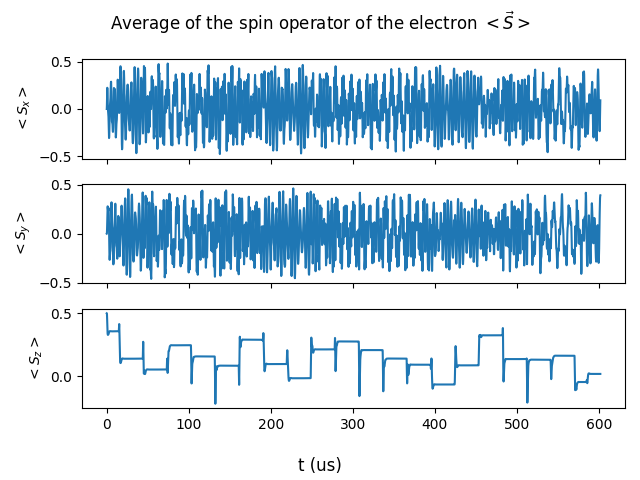

In [29]:
inspect_electron_spin(t, result, S, nI_1, nI_2)

array([<AxesSubplot:ylabel='$<I_x>$'>, <AxesSubplot:ylabel='$<I_y>$'>,
       <AxesSubplot:ylabel='$<I_z>$'>], dtype=object)

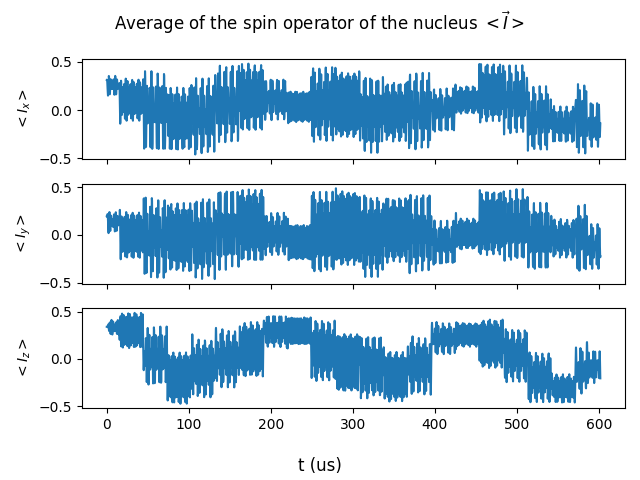

In [30]:
inspect_nuclear_spin(1, t, result, I, nS, nI_2) # Inspect nuclear spin #1

array([<AxesSubplot:ylabel='$<I_x>$'>, <AxesSubplot:ylabel='$<I_y>$'>,
       <AxesSubplot:ylabel='$<I_z>$'>], dtype=object)

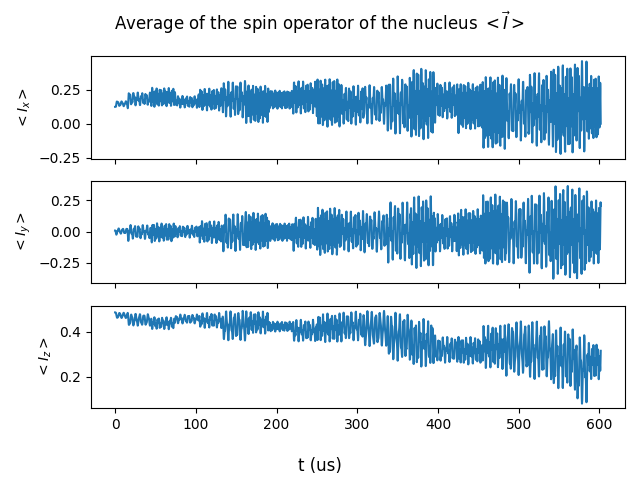

In [32]:
inspect_nuclear_spin(2, t, result, I, nS, nI_1) # Inspect nuclear spin #2

In [34]:
# Simulating for different values of tau for the nuclear spins #1 and #2 defined above
tau_list = np.linspace(5, 30, 2001)
N_pulses = 20

p_x = np.zeros([len(tau_list)])

pool = Pool(worker_count)

args = [(H, ket0, {'tau':tau, 'pulse_duration':pulse_duration, 'rabi_freq':rabi_freq, 'kappa':kappa, 'kappa_c':kappa_c, 'N_pulses':N_pulses}, nS, nI_1, nI_2) for tau in tau_list]
p_x = pool.starmap(parallelize_CPMG, args)
    
pool.close()

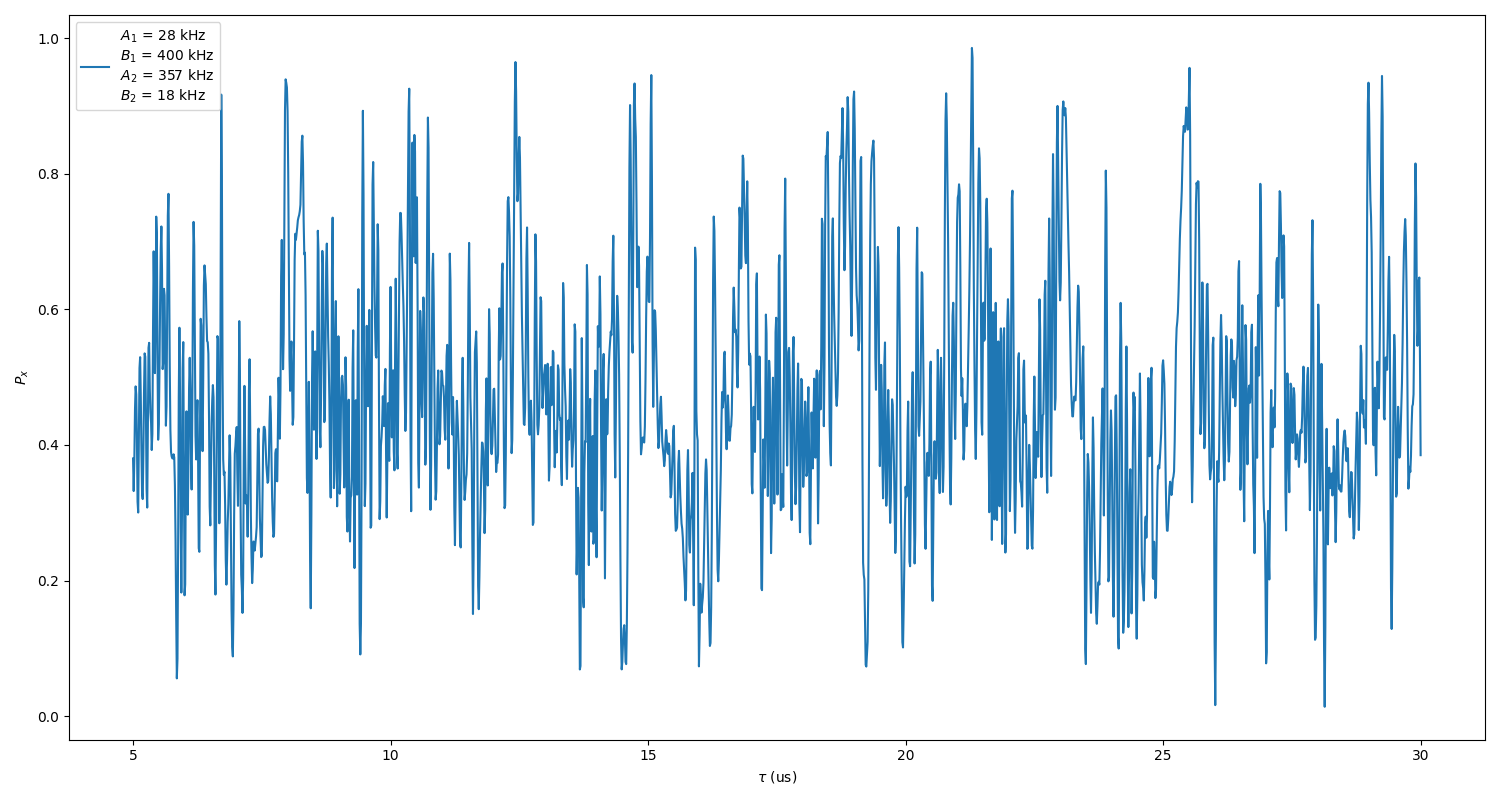

In [35]:
fig, axes = plt.subplots(1, 1, tight_layout=True, figsize=(15,8))
axes.set(
    xlabel=r"$\tau$ (us)",
    ylabel=r"$P_x$"
)

axes.plot(tau_list, p_x, label="$A_1$ = %d kHz\n$B_1$ = %d kHz\n$A_2$ = %d kHz\n$B_2$ = %d kHz"%(A_1/(2*np.pi)*1e3,B_1/(2*np.pi)*1e3,A_2/(2*np.pi)*1e3,B_2/(2*np.pi)*1e3))
axes.legend()